# Importing and Tidying the Data

In [1]:
# import stuff
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [3]:
#import the data from csv file with a series of NAN values 
df1 = pd.read_csv('./../data/highered_00004.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df1 = df1.drop(['REFID'], axis=1)
df2 = pd.read_csv('./../data/highered_00007.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df3 = pd.read_csv('./../data/highered_00008.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
dfm = df1.merge(df2,  on=['PERSONID', 'YEAR', 'WEIGHT', 'SAMPLE', 'SURID'])

In [4]:
# explanation of the survey https://highered.ipums.org/highered/survey_designs.shtml

# Respondents from each of these three surveys with science or engineering degrees                               ##
# or occupations are compiled into one dataset: the SESTAT (the Scientists and Engineers Statistical Data System)##
df = dfm.merge(df3, on=['PERSONID', 'YEAR', 'SURID'])


In [5]:
df_employed = df[df['LFSTAT']==1]
df_employed_small = df_employed.drop(['CTZUS', 'WEIGHT', 'WRKG', 'NRREA','FNVS', 'CHTOT', 'CPI2009C', 'PERSONID', 'LFSTAT','BA03Y5', 'LOOKWK'], axis=1)
#df_employed_small.info()

In [6]:
#df_employed_l = df_employed_small[df_employed_small.SALARY != 150000]
#df_employed_l = df_employed_small[df_employed_small['NDGMEMG']==3].dropna()
df_employed_l = df_employed_small.dropna()

Next we use pandas' correlation funcion and seaborns heatmap to get a general idea of how the features are related to each other.

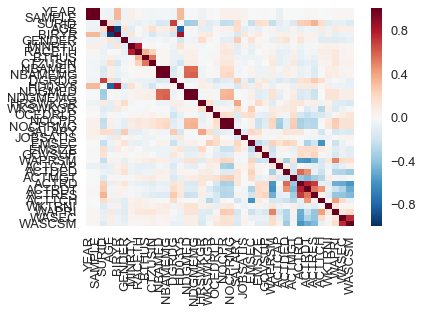

In [7]:
sns.heatmap(df_employed_l.corr())

In [8]:
df_employed_l.corr()['SALARY']

YEAR        0.047753
SAMPLE      0.049694
SURID       0.193761
AGE         0.186057
BIRYR      -0.162161
GENDER      0.257586
MINRTY     -0.102562
RACETH     -0.101382
BTHUS      -0.055799
CTZUSIN     0.012500
NBAMED     -0.037537
NBAMEMG    -0.034085
DGRDG       0.263496
HD03Y5     -0.167808
NDGMED     -0.010046
NDGMEMG    -0.001453
HRSWKGR     0.403946
WKSWKGR     0.176768
OCEDRLP    -0.128177
NOCPR      -0.091245
NOCPRMG    -0.056801
SALARY      1.000000
JOBSATIS   -0.140447
EMSEC       0.215927
EMSIZE      0.169909
GOVSUP      0.022820
WAPRSM     -0.034008
ACTCAP      0.042460
ACTDED      0.126313
ACTMGT      0.119822
ACTRD       0.115217
ACTRDT     -0.012041
ACTRES      0.036424
ACTTCH     -0.183005
WKTRNI      0.007476
WAPRI      -0.172204
WASEC      -0.133979
WASCSM     -0.141206
Name: SALARY, dtype: float64

Looks like many of the columns are catagorical and has been stored in the same column as numbers, such as the field of major, highest degree and etc. They need to be treated that way. Here pandas get_dummies are used for this purpose. 

In [9]:
df_employed_d = pd.get_dummies(df_employed_l, columns=['RACETH','NBAMED', 'NBAMEMG', 'NDGMED', 'EMSEC','EMSIZE', 'GOVSUP', 'NDGMEMG', 'OCEDRLP', 'WAPRSM', 'WAPRI', 'WKTRNI', 'WASEC', 'NOCPR','WASCSM', 'NOCPRMG', 'SAMPLE', 'HD03Y5', 'DGRDG', 'JOBSATIS','SURID','HRSWKGR','WKSWKGR'], drop_first=True)

In [10]:
X = df_employed_d[df_employed_d['YEAR']==2013].drop(['SALARY'], axis=1)
y = df_employed_d[df_employed_d['YEAR']==2013]['SALARY']

#import the machine learning algorithm packages
# Import modules of linear regresssion, evaluation, and train test split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Import Lasso
from sklearn.linear_model import Lasso
# Import Ridge
from sklearn.linear_model import Ridge


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg
reg = Ridge()


# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


0.558807434679
Root Mean Squared Error: 27269.00915709602


Only looking at the data where salary is not 0. The R2 improved slightly. 

In [11]:
df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]
X = df_employed_no[df_employed_no['YEAR']==2013].drop(['SALARY'], axis=1)
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']

#import the machine learning algorithm packages
# Import modules of linear regresssion, evaluation, and train test split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Import Lasso
from sklearn.linear_model import Lasso
# Import Ridge
from sklearn.linear_model import Ridge


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg
reg = Ridge()


# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Cap the predicted value at 150000 as in the original data set 
y_pred = np.clip(y_pred, 0, 150000)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


0.56604040661
Root Mean Squared Error: 26671.457390859796


In [12]:

#make functions to calculate coefficient of determination 
from statistics import mean

def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)



print(coefficient_of_determination(y_test, y_pred))

0.569684405838


#### The ridge and simple linear regression both give the determination coefficient ($R^2$) result of 0.51. It is not bad considering some essential fact contributing to the salary is unknown: level of the position, location of the job,  and company pay ability. This next cell shows a histogram of the actual salaries and the predicted salaries. We see the distribution of predected salary is more centrally located around the mean. Can this give us a hint as to what to do next?

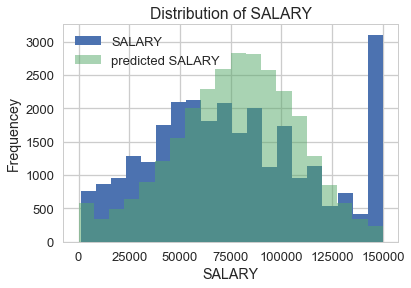

In [13]:
plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()

In [14]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary() )
#m3 = ols(formula='SALARY ~ ALL',data = df_employed_d).fit()
#print(m3.summary())

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     896.8
Date:                Sat, 21 Apr 2018   Prob (F-statistic):               0.00
Time:                        22:10:56   Log-Likelihood:            -1.0939e+06
No. Observations:               94233   AIC:                         2.188e+06
Df Residuals:                   94092   BIC:                         2.189e+06
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
YEAR               49.0689     62.176     

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Above gives the result from the linear regresssion by statsmodel. We see the correlation is statistically significant (p-value from the F-statistic). The R^2 score is consistent with what is given by sklearn linear models. 

How about polynomial regression? => not improving the result at degree =2. At degree =3, it is taking too long to finish running. 

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

df_sample = df_employed_no.sample(frac=0.01, random_state=42)

X_s = df_sample.drop(['SALARY'], axis=1)
y_s = df_sample['SALARY']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state=42)



model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                   ('linear', LinearRegression())])

# fit to an order-2 polynomial data

model.fit(X_train, y_train)

# Compute predictions over the prediction space: y_pred
y_pred = model.predict(X_test)

# Print R^2 
print(model.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


-0.112920954541
Root Mean Squared Error: 41257.78101548474


I tried to use the log of the target feature (salary), it gave a better result (0.57=>0.6) when taking a power of 6.

In [16]:
df_sample = df_employed_no[df_employed_no['YEAR']==2013]
#.sample(frac=0.2, random_state=42)

X_s = df_sample.drop(['SALARY'], axis=1)
y_s = np.log(df_sample['SALARY'])**6

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state=41)

reg = LinearRegression()

# fit to an order-2 polynomial data

reg.fit(X_train, y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))



0.603876529305
Root Mean Squared Error: 391760.7756809568


In [17]:
#Use grid search for random forest regressor
# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
X = df_employed_no[df_employed_no['YEAR']==2013].drop(['SALARY'], axis=1)
y = df_employed_no[df_employed_no['YEAR']==2013]['SALARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=41)

param_grid = {"n_estimators": [10, 30, 50],
              "max_features": [10, 30],
              "max_depth": [10, 100, 300]
              }

# Instantiate a logistic regression classifier: logreg
rfr = RandomForestRegressor()

# Instantiate the GridSearchCV object: logreg_cv
rfr_cv = GridSearchCV(rfr, param_grid, cv=5)

# Fit it to the data
rfr_cv.fit(X_train,y_train)

y_rfr_cv = rfr_cv.predict(X_test)

rmse_rfr_cv = np.sqrt(mean_squared_error(y_test,y_rfr_cv))

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfr_cv.best_params_)) 
print("Best score is {}".format(rfr_cv.best_score_))

# test data result
print("Score on the test data is: ", rfr_cv.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rfr_cv))

Tuned Logistic Regression Parameters: {'max_depth': 100, 'max_features': 30, 'n_estimators': 50}
Best score is 0.5811330633518617
Score on the test data is:  0.595794739739
RBF Root Mean Squared Error: 25896.954048373027


0.596449879433
RBF Root Mean Squared Error: 25875.958523932582


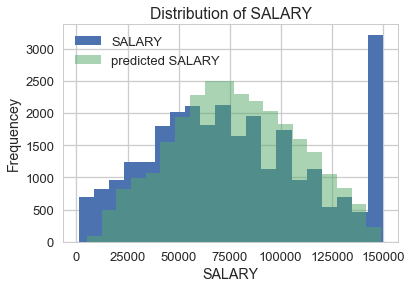

In [18]:
## Trying random forest regressor 
df_sample = df_employed_no[df_employed_no['YEAR']==2013]
#.sample(frac=0.2, random_state=42)

X_s = df_sample.drop(['SALARY'], axis=1)
y_s = df_sample['SALARY']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state=41)


from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=50, max_features=50, max_depth=100)

#rfr.fit(X,y)
# Use feature selection
#model = SelectFromModel(rfr, prefit=True)
#X_new = model.transform(X)

#train test split
#X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=42)

y_rfr = rfr.fit(X_train, y_train).predict(X_test)

#y_rfr = np.clip(y_rfr, 0, 150000)

rmse_rfr = np.sqrt(mean_squared_error(y_test,y_rfr))

# Print R2
print(rfr.score(X_test, y_test))
#print(coefficient_of_determination(y_test, y_rfr))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rfr))


plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_rfr,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()

Delete rows with 150000 salary and try the regression again. Linear regression:

0.544967460751
Root Mean Squared Error: 23092.40543115738


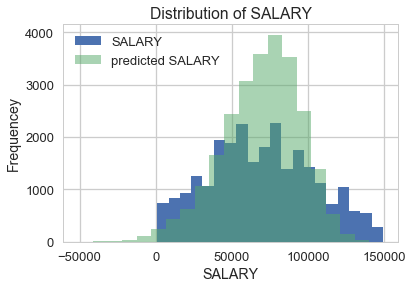

In [19]:
## Regression on data with less than 150000 salary


df_decap = df_sample[df_sample['SALARY']<150000]
X = df_decap.drop(['SALARY'], axis=1)
y = df_decap['SALARY']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
#y_pred = np.clip(y_pred, 0, 150000)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

#visualize the actual and predicted salaries 
plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()


Random forest regressor with less 150000 salary entries:

Score on the test data is:  0.555578915709
Root Mean Squared Error: 22821.557169649124


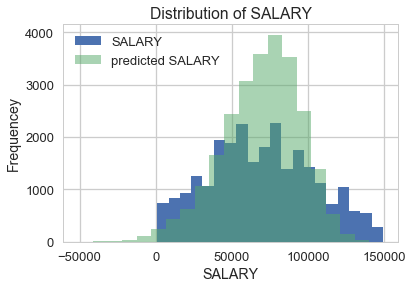

In [20]:
# Instantiate a random forest regressor
rfr = RandomForestRegressor(n_estimators=100, max_features=25, max_depth=100)

# Fit it to the data
rfr.fit(X_train,y_train)

y_rfr = rfr.predict(X_test)

rmse_rfr = np.sqrt(mean_squared_error(y_test,y_rfr))

# test data result
print("Score on the test data is: ", rfr.score(X_test, y_test))

# Print RMSE
print("Root Mean Squared Error: {}".format(rmse_rfr))


#visualize the actual and predicted salaries 
plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()


#### The result does not seem better when neglecting the capped target rows!

Use feature selection and try the regression again.

shape of X:  (94233, 183)
shape of X_new:  (94233, 41)
0.206984250494
Root Mean Squared Error: 36207.13081887106


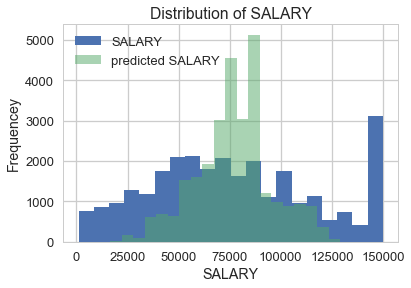

In [21]:
X = df_sample.drop(['SALARY'], axis=1)
y = df_sample['SALARY']

reg = LinearRegression()
reg.fit(X,y)

from sklearn.feature_selection import SelectFromModel
#Use feature selection
model = SelectFromModel(reg, prefit=True)
X_new = model.transform(X)

print("shape of X: ", X.shape)
print("shape of X_new: ", X_new.shape)
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=42)

# Fit the model to the new data
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = np.clip(y_pred, 0, 150000)


# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

# your turn

plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()


#### The score ($R^2$) did not improve with the data processing of feature selection. 

In [22]:
## Trying SVR 
from sklearn.svm import SVR

df_sample = df_employed_no.sample(frac=0.1, random_state=42)

X = df_sample.drop(['SALARY'], axis=1)
y = df_sample['SALARY']


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


svr_rbf = SVR(kernel='rbf', C=120000, gamma=0.005)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
#y_lin = svr_fit(X_train, y_train).predict(X_test)
#y_poly = svr_fit(X_train, y_train).predict(X_test)

rmse_rbf = np.sqrt(mean_squared_error(y_test,y_rbf))
#rmse_lin = np.sqrt(mean_squared_error(y_test,y_lin))
#rmse_poly = np.sqrt(mean_squared_error(y_test,y_poly))

# Print R^2 
print(svr_rbf.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rbf))
#print("LIN Root Mean Squared Error: {}".format(rmse_lin))
#print("Poly Root Mean Squared Error: {}".format(rmse_poly))

0.548718111248
RBF Root Mean Squared Error: 26649.728727767124


In [23]:
# Trying to predict NOCPRMG or WAPRSM

In [24]:
#df_employed_clf = df_employed_no
df_employed_clf =[]
df_employed_clf = df_employed_l[df_employed_l['SALARY']>0]
df_employed_clf.columns

Index(['YEAR', 'SAMPLE', 'SURID', 'AGE', 'BIRYR', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'HRSWKGR', 'WKSWKGR', 'OCEDRLP', 'NOCPR', 'NOCPRMG',
       'SALARY', 'JOBSATIS', 'EMSEC', 'EMSIZE', 'GOVSUP', 'WAPRSM', 'ACTCAP',
       'ACTDED', 'ACTMGT', 'ACTRD', 'ACTRDT', 'ACTRES', 'ACTTCH', 'WKTRNI',
       'WAPRI', 'WASEC', 'WASCSM'],
      dtype='object')

In [25]:
#classify genders from other features: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


X = df_employed_clf.drop(['GENDER'], axis=1)
y = df_employed_clf['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[27944 16728]
 [10787 61510]]
             precision    recall  f1-score   support

          1       0.72      0.63      0.67     44672
          2       0.79      0.85      0.82     72297

avg / total       0.76      0.76      0.76    116969



In [26]:
#classify genders from other features: KNN

from sklearn.neighbors import KNeighborsClassifier


X = df_employed_clf.drop(['GENDER'], axis=1)
y = df_employed_clf['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = KNeighborsClassifier(n_neighbors=20)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[24951 19721]
 [14756 57541]]
             precision    recall  f1-score   support

          1       0.63      0.56      0.59     44672
          2       0.74      0.80      0.77     72297

avg / total       0.70      0.71      0.70    116969



In [27]:

#predict gender for engineering jobs (mostly men, 15% women)


X = df_employed_clf[df_employed_clf['NOCPRMG']==5].drop(['GENDER'], axis=1)
y = df_employed_clf[df_employed_clf['NOCPRMG']==5]['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=30, max_features=25, max_depth=200)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  561  2191]
 [  492 14696]]
             precision    recall  f1-score   support

          1       0.53      0.20      0.29      2752
          2       0.87      0.97      0.92     15188

avg / total       0.82      0.85      0.82     17940



In [28]:
#predict gender for social science jobs (almost the same men and women in the field)

X = df_employed_clf[df_employed_clf['NOCPRMG']==4].drop(['GENDER'], axis=1)
y = df_employed_clf[df_employed_clf['NOCPRMG']==4]['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=30, max_features=25, max_depth=200)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[3815 1205]
 [1620 2997]]
             precision    recall  f1-score   support

          1       0.70      0.76      0.73      5020
          2       0.71      0.65      0.68      4617

avg / total       0.71      0.71      0.71      9637



In [29]:
#classify the field of job from other columns 
#Use dummied data to model

df_employed_field = pd.get_dummies(df_employed_l, columns=['RACETH','NBAMED', 'NBAMEMG', 'NDGMED', 'EMSEC','EMSIZE', 'GOVSUP', 'NDGMEMG', 'OCEDRLP', 'WAPRSM', 'WAPRI', 'WKTRNI', 'WASEC', 'WASCSM', 'SAMPLE', 'HD03Y5', 'DGRDG', 'JOBSATIS','SURID','HRSWKGR','WKSWKGR'], drop_first=True)
df_employed_field_no = df_employed_field[df_employed_field['SALARY']!=0]
X = df_employed_field_no[df_employed_no['GENDER']==1].drop(['NOCPRMG','NOCPR'], axis=1)
y = df_employed_field_no[df_employed_no['GENDER']==1]['NOCPRMG']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 3096    78    36    62   192   239   646]
 [   51  3064   186    91    69   375   306]
 [   25   235  1354    20    77    92   166]
 [   55    67    11  3960    11   153   781]
 [  216    50    83     6  2199    63   225]
 [  495   584   105   131   224  8186  1538]
 [  356   292   101   690   295  1199 12123]]
             precision    recall  f1-score   support

        1.0       0.72      0.71      0.72      4349
        2.0       0.70      0.74      0.72      4142
        3.0       0.72      0.69      0.70      1969
        4.0       0.80      0.79      0.79      5038
        5.0       0.72      0.77      0.74      2842
        6.0       0.79      0.73      0.76     11263
        7.0       0.77      0.81      0.79     15056

avg / total       0.76      0.76      0.76     44659



In [30]:
#predict the field of job from other columns 
#Use original data to feed into random forest classifier

X = df_employed_clf[df_employed_clf['GENDER']==1].drop(['NOCPRMG','NOCPR'], axis=1)
y = df_employed_clf[df_employed_clf['GENDER']==1]['NOCPRMG']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 3116    82    36    70   193   245   607]
 [   59  3052   187    92    57   400   295]
 [   26   227  1355    18    72   100   171]
 [   53    78    11  3961    13   136   786]
 [  208    53    92     4  2182    65   238]
 [  476   574   104   144   212  8190  1563]
 [  359   296   117   731   279  1158 12116]]
             precision    recall  f1-score   support

        1.0       0.73      0.72      0.72      4349
        2.0       0.70      0.74      0.72      4142
        3.0       0.71      0.69      0.70      1969
        4.0       0.79      0.79      0.79      5038
        5.0       0.73      0.77      0.75      2842
        6.0       0.80      0.73      0.76     11263
        7.0       0.77      0.80      0.79     15056

avg / total       0.76      0.76      0.76     44659



#### Dummied and original data gave the same result with the random forest classifier

In [31]:
# Predict women prime job activity from other not related columns 

X = df_employed_clf[df_employed_clf['GENDER']==1].drop(['SALARY', 'WAPRSM', 'WAPRI', 'WASEC','WASCSM'], axis=1)
y = df_employed_clf[df_employed_clf['GENDER']==1]['WAPRSM'].astype('category')

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7798  538  744  258  254]
 [ 310 7045  190   10  246]
 [1068  449 9401  261  937]
 [ 242   32  223 1812   65]
 [ 756  357 1939   87 9637]]
             precision    recall  f1-score   support

        1.0       0.77      0.81      0.79      9592
        2.0       0.84      0.90      0.87      7801
        3.0       0.75      0.78      0.76     12116
        4.0       0.75      0.76      0.75      2374
        5.0       0.87      0.75      0.81     12776

avg / total       0.80      0.80      0.80     44659



### Unsupervised learning 

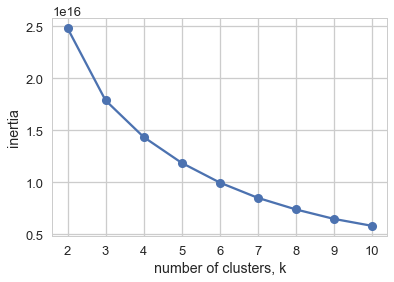

In [32]:
## Unsupervised learning model K means to find clusters.
## find number of clusters first

#X = df_employed_clf[df_employed_clf['NOCPRMG']==5].drop(['GENDER'], axis=1)
X = df_employed_clf.drop(['SALARY'], axis=1)

from sklearn.cluster import KMeans

#choose number of clusters by inertia

inertia = []
ks=range(2,11)

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
     # Append the inertia to the list of inertias
    inertia.append(model.inertia_)
    
plt.plot(ks, inertia, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#elbow point k=3

Use the number of clusters found above to cluster with KMeans. (original columns)

mean salary of the clusters: cluster
0    77561.958406
1    77875.235701
Name: salary, dtype: float64


/anaconda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


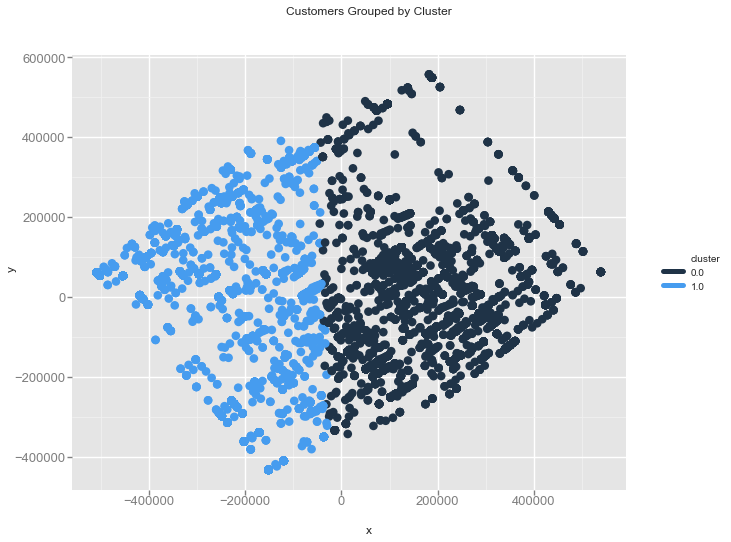

<ggplot: (-9223372036564189461)>

In [33]:
#Use original columns to find clusters

model = KMeans(n_clusters=2)
X_sample_o = df_employed_clf.sample(frac=0.02, random_state=41)
X_sample = X_sample_o.drop(['SALARY'], axis=1)
clster = model.fit_predict(X_sample)

#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X_sample)


X_sample['x'] = pca.fit_transform(X_sample)[:,0]
X_sample['y'] = pca.fit_transform(X_sample)[:,1]
X_sample['cluster'] = clster
X_sample['salary'] = X_sample_o['SALARY']
print('mean salary of the clusters:', X_sample.groupby('cluster').salary.mean())
                     
from ggplot import *

ggplot(X_sample, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")
    
    


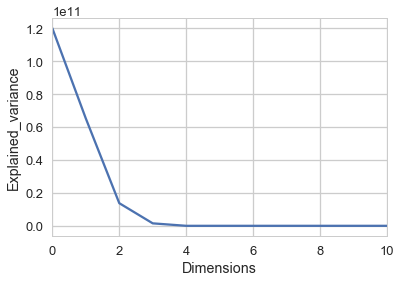

In [34]:
#your turn

# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(X_sample)

#plot explained variance
plt.plot(pca.explained_variance_)
plt.xlim([0,10])
plt.xlabel('Dimensions')
plt.ylabel('Explained_variance')



In [35]:
## Look at the difference of clusters: seems like the majors and fields are different
X_sample.groupby('cluster').mean().transpose()

cluster,0,1
YEAR,2008.323873,2008.239786
SAMPLE,814.094887,811.610308
SURID,1.183276,1.522313
AGE,45.349653,44.927404
BIRYR,1960.955373,1961.332495
GENDER,1.604636,1.631992
MINRTY,0.198440,0.165305
RACETH,2.054809,1.996857
BTHUS,0.775347,0.750157
CTZUSIN,0.931109,0.896292


Use the number of clusters found above to cluster with KMeans. (dummied column) We notice a different results from clustered with original columns.

mean salary of the clusters: cluster
0    71464.570858
1    84273.087071
Name: salary, dtype: float64


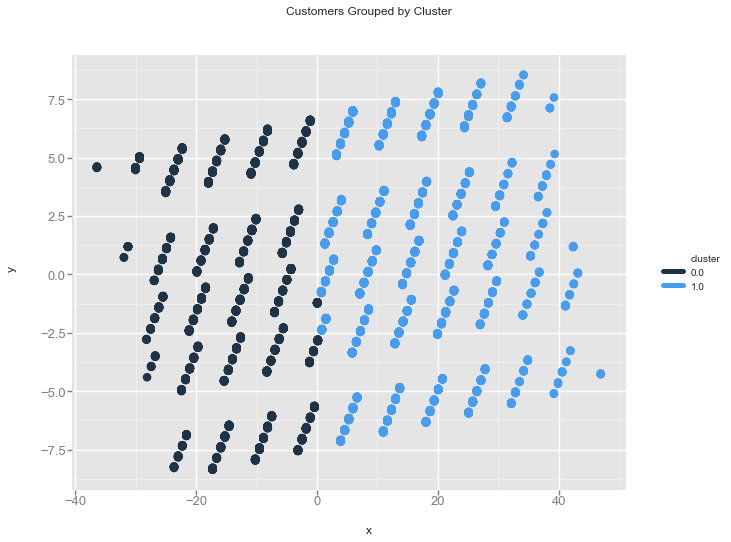

<ggplot: (290527485)>

In [36]:
#Use dummied columns to find clusters

model = KMeans(n_clusters=2)
X_sample_o = df_employed_no.sample(frac=0.02, random_state=41)
X_sample = X_sample_o.drop(['SALARY'], axis=1)
clster = model.fit_predict(X_sample)

#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X_sample)


X_sample['x'] = pca.fit_transform(X_sample)[:,0]
X_sample['y'] = pca.fit_transform(X_sample)[:,1]
X_sample['cluster'] = clster
X_sample['salary'] = X_sample_o['SALARY']

print('mean salary of the clusters:', X_sample.groupby('cluster').salary.mean())
                     
from ggplot import *

ggplot(X_sample, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")
    

Cluster with some other unsupervised ML models. DBSCAN.

In [37]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(labels)
print(n_clusters_)

[-1 -1 -1 ..., -1 -1 -1]
28


Change the salary column from numeric to catagorical. Define the discrete steps.

In [38]:
def salary_bracket(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s<50000:
            new_s[i] = 1
        elif s<100000:
            new_s[i] = 2
        elif s<150000:
            new_s[i] = 3
        else:
            new_s[i] = 4
    return new_s

new_salary = salary_bracket(df_employed_clf[df_employed_clf['YEAR']==2013]['SALARY'])


In [39]:
df_employed_nod = []
df_employed_nod = df_employed_clf[df_employed_clf['YEAR']==2013].assign(salary_d=pd.Series(new_salary).values)

In [40]:
df_employed_nod.salary_d = df_employed_nod.salary_d.astype('category')
df_employed_nod=df_employed_nod.drop(['SALARY'], axis=1)

In [41]:
X = df_employed_nod[(df_employed_nod['GENDER']==1)].drop(['salary_d'], axis=1)
y = df_employed_nod[(df_employed_nod['GENDER']==1)]['salary_d']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
#clf = LogisticRegression()
clf = RandomForestClassifier(n_estimators=50, max_depth=100)
#from sklearn.svm import SVC
#clf = SVC()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3264 1111   33    4]
 [ 908 4197  263   53]
 [  71  974  398   98]
 [  39  251  184  161]]
             precision    recall  f1-score   support

        1.0       0.76      0.74      0.75      4412
        2.0       0.64      0.77      0.70      5421
        3.0       0.45      0.26      0.33      1541
        4.0       0.51      0.25      0.34       635

avg / total       0.66      0.67      0.65     12009



In [42]:
## Trying SVC and MLP classifier

X = df_employed_nod[(df_employed_nod['GENDER']==1)].drop(['salary_d'], axis=1)
df_employed_nod_dummy = pd.get_dummies(df_employed_nod, columns=['salary_d'], drop_first=True)
y = df_employed_nod_dummy[(df_employed_nod_dummy['GENDER']==1)]['salary_d_3.0']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
#clf = LogisticRegression()
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)
from sklearn.svm import SVC
clf = SVC()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10409    59]
 [ 1501    40]]
             precision    recall  f1-score   support

          0       0.87      0.99      0.93     10468
          1       0.40      0.03      0.05      1541

avg / total       0.81      0.87      0.82     12009



In [43]:
from sklearn.neural_network import MLPClassifier
X = df_employed_nod[(df_employed_nod['GENDER']==1)].drop(['salary_d'], axis=1)
df_employed_nod_dummy = pd.get_dummies(df_employed_nod, columns=['salary_d'], drop_first=True)
y = df_employed_nod_dummy[(df_employed_nod_dummy['GENDER']==1)]['salary_d_3.0']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = MLPClassifier()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10457    11]
 [ 1538     3]]
             precision    recall  f1-score   support

          0       0.87      1.00      0.93     10468
          1       0.21      0.00      0.00      1541

avg / total       0.79      0.87      0.81     12009

